In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
yf.pdr_override()
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

### I. Load dữ liệu

In [2]:
# Thời gian để load dữ liệu train mô hình
startdate = datetime(2013,1,1)
enddate = datetime(2023,12,31)
y_symbols = ['AAPL'] #Thử nghiệm với mã cổ phiếu của Apple

In [3]:
# Đọc dữ liệu từ API của Yahoo Finance
df = pdr.get_data_yahoo(y_symbols, start=startdate, end=enddate).reset_index()
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02 00:00:00-05:00,19.779285,19.821428,19.343929,19.608213,16.747719,560518000
1,2013-01-03 00:00:00-05:00,19.567142,19.631071,19.321428,19.360714,16.536329,352965200
2,2013-01-04 00:00:00-05:00,19.177500,19.236786,18.779642,18.821428,16.075716,594333600
3,2013-01-07 00:00:00-05:00,18.642857,18.903570,18.400000,18.710714,15.981157,484156400
4,2013-01-08 00:00:00-05:00,18.900356,18.996071,18.616072,18.761070,16.024164,458707200


Dữ liệu gồm có các trường thông tin sau:

- Date: Ngày giao dịch
- Open: Giá mở của mã cổ phiếu trong ngày giao dịch
- High: Giá giao dịch cao nhất của mã cổ phiếu trong ngày giao dịch
- Low: Giá giao dịch thấp nhất của mã cổ phiếu trong ngày giao dịch
- Close: Giá đóng phiên giao dịch của mã cổ phiếu trong ngày giao dịch
- Adj Close: Giá đóng phiên giao dịch điều chỉnh của mã cổ phiếu trong ngày giao dịch
- Volumn: Khối lượng giao dịch của mã cổ phiếu trong ngày giao dịch

### II. Data preprocessing and understanding

In [4]:
# Loại bỏ trường thông tin không sử dụng
df = df.drop(['Date','Adj Close'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,19.779285,19.821428,19.343929,19.608213,560518000
1,19.567142,19.631071,19.321428,19.360714,352965200
2,19.177500,19.236786,18.779642,18.821428,594333600
3,18.642857,18.903570,18.400000,18.710714,484156400
4,18.900356,18.996071,18.616072,18.761070,458707200


In [5]:
# Kiểm tra giá trị missing
df["Close"].isna().sum()

# => Không có giá trị missing nào

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2768 non-null   float64
 1   High    2768 non-null   float64
 2   Low     2768 non-null   float64
 3   Close   2768 non-null   float64
 4   Volume  2768 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 108.2 KB


In [7]:
df.describe()

,Open,High,Low,Close,Volume
count,2768.000000,2768.000000,2768.000000,2768.000000,2.768000e+03
mean,72.306914,73.092193,71.567077,72.363529,1.612260e+08
std,56.353981,56.992647,55.763624,56.411026,1.236387e+08
min,13.856071,14.271429,13.753571,13.947500,2.404830e+07
25%,27.574999,27.933750,27.295626,27.588126,8.424670e+07
50%,43.835001,44.312500,43.623751,43.958752,1.211314e+08
75%,128.952499,130.627506,127.415003,129.612499,1.957962e+08
max,198.020004,199.619995,197.000000,198.110001,1.460852e+09


### Mô hình sẽ mô phỏng và dự đoán giá đóng phiên (Close) của mã cổ phiếu 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


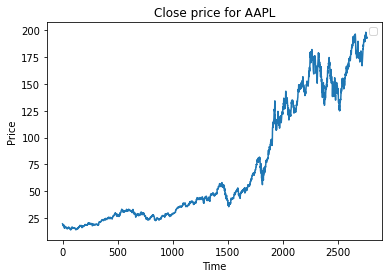

In [8]:
# Biểu đồ giá đóng phiên của mã cổ phiếu
plt.plot(df.Close)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title("Close price for AAPL")

plt.show()


In [9]:
# Tính Moving Average 100 days
ma100 = df.Close.rolling(100).mean()
ma100

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
2763    181.768301
2764    181.787101
2765    181.898701
2766    182.046001
2767    182.173301
Name: Close, Length: 2768, dtype: float64

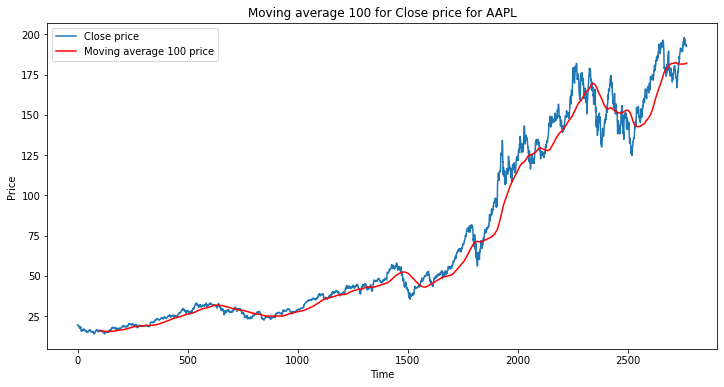

In [10]:
# Biểu đồ Moving Average 100 ngày so sánh với biến động giá đóng phiên của mã cổ phiếu
plt.figure(figsize=(12,6))
plt.plot(df.Close, label="Close price")
plt.plot(ma100,'r', label="Moving average 100 price")
plt.legend()
plt.title("Moving average 100 for Close price for AAPL")
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


### III. Train-test split & Data preparation for model training

In [11]:
# Tách tập train và tập test với tỉ lệ 70% - 30%
data_train = pd.DataFrame(df['Close'][0:int(len(df)*0.7)])
data_test = pd.DataFrame(df['Close'][int(len(df)*0.7):len(df)])
data_train.shape


(1937, 1)

In [12]:
# Transform scale 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
data_train_array = scaler.fit_transform(data_train)
data_test_array = scaler.fit_transform(data_test)
data_train_array.size

1937

In [13]:


# Tạo dữ liệu x_train và dữ liệu nhãn y_train
x_train = []
y_train = []

for i in range(100, data_train_array.shape[0]):
    x_train.append(data_train_array[i-100:i])  
    y_train.append(data_train_array[i,0])      


# Tạo dữ liệu x_test và dữ liệu nhãn y_test
x_test = []
y_test = []

for i in range(100, data_test_array.shape[0]):
    x_test.append(data_test_array[i-100:i])
    y_test.append(data_test_array[i,0])


In [14]:
# Chuyển dữ liệu về dạng array

x_train, y_train = np.array(x_train), np.array(y_train)
print("Data train:")
print(x_train.size)
print(y_train.size)

print("Dữ liệu test:")
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.size)
print(y_test.size)

Data train:
183700
1837
Dữ liệu test:
73100
731


### IV. Train model

In [15]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [16]:
# Define các layers cho thuật toán LSTM
model = Sequential()
model.add(LSTM(units= 50, activation = 'relu', return_sequences= True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))


model.add(LSTM(units= 60, activation = 'relu', return_sequences= True))
model.add(Dropout(0.3))


model.add(LSTM(units= 80, activation = 'relu', return_sequences= True))
model.add(Dropout(0.4))

model.add(LSTM(units= 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))



In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [18]:
# Train mô hình
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
58/58 [==============================] - 26s 325ms/step - loss: 0.0148
Epoch 2/50
58/58 [==============================] - 19s 324ms/step - loss: 0.0032
Epoch 3/50
58/58 [==============================] - 18s 318ms/step - loss: 0.0036
Epoch 4/50
58/58 [==============================] - 18s 318ms/step - loss: 0.0028
Epoch 5/50
58/58 [==============================] - 18s 313ms/step - loss: 0.0029
Epoch 6/50
58/58 [==============================] - 18s 316ms/step - loss: 0.0024
Epoch 7/50
58/58 [==============================] - 18s 309ms/step - loss: 0.0023
Epoch 8/50
58/58 [==============================] - 18s 315ms/step - loss: 0.0024
Epoch 9/50
58/58 [==============================] - 18s 306ms/step - loss: 0.0021
Epoch 10/50
58/58 [==============================] - 18s 308ms/step - loss: 0.0019
Epoch 11/50
58/58 [==============================] - 17s 298ms/step - loss: 0.0020
Epoch 12/50
58/58 [==============================] - 17s 295ms/step - loss: 0.0020
Epoch 13/50
5

In [19]:
# Hàm tính mae

def mae(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

In [41]:
# Evaluate model
y_predict = model.predict(x_test)

scale = scaler.scale_

scaler_factor = 1/scale[0]
y_predicted_1 = y_predict * scaler_factor
y_test_1 = y_test * scaler_factor

mae = mean_absolute_error(y_test_1, y_predicted_1)
print("MAE: ", mae)


23/23 [==============================] - 2s 68ms/step
MAE:  5.358621712096251


In [21]:
# Save model to folder
model.save('stock_pre.h5')

### V. Hyperparameter tunning

In [23]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

In [24]:
# Define một hàm để tạo mô hình LSTM

# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist
        

In [25]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test)  # change x_train shape

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------
Epoch 9: early stopping
0-th combination = (False, False, False, 16, 8, 0.2) 
 train accuracy: [0.0003988739917986095, 0.019971830770373344] and test accuracy: [0.0044867065735161304, 0.06698288023471832]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
2th combination: 

--------------------------------------------------------------------
Epoch 9: early stopping
1-th combination = (False, False, False, 16, 16, 0.2) 
 train accuracy: [0.0008451705798506737, 0.02907181717455387] and test accuracy: [0.008308668620884418, 0.0911519005

In [26]:
# Choosing the best model

hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
3,False,False,False,32,8,0.2,"[0.00019463735225144774, 0.013951249420642853]","[0.0021344413980841637, 0.046200014650821686]"
0,False,False,False,16,8,0.2,"[0.0003988739917986095, 0.019971830770373344]","[0.0044867065735161304, 0.06698288023471832]"
2,False,False,False,16,32,0.2,"[0.00043476521386764944, 0.020851023495197296]","[0.00502646341919899, 0.07089754939079285]"
5,False,False,False,32,32,0.2,"[0.00048397979116998613, 0.02199953980743885]","[0.005298966076225042, 0.07279399782419205]"
4,False,False,False,32,16,0.2,"[0.0006542017217725515, 0.025577368214726448]","[0.006305658724159002, 0.0794081762433052]"
1,False,False,False,16,16,0.2,"[0.0008451705798506737, 0.02907181717455387]","[0.008308668620884418, 0.0911519005894661]"


In [27]:
# Result

print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(y_predict, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((y_predict[1] - hist.iloc[0, -1][1])*100/np.round(y_predict, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 8
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: [0.3121]

Results After Tunning:
 Test Set RMSE: 0.0462

[85.]% Improvement


In [28]:
# Retrain with Best hyperparameter

first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

best_model = Sequential()
best_model.add(LSTM(units= 32, activation = 'relu', return_sequences= True, input_shape = (x_train.shape[1],1)))
best_model.add(Dropout(0.2))

best_model.add(LSTM(units= 60, activation = 'relu', return_sequences= True))
best_model.add(Dropout(0.3))


best_model.add(LSTM(units= 80, activation = 'relu', return_sequences= True))
best_model.add(Dropout(0.4))

best_model.add(LSTM(units= 120, activation = 'relu'))
best_model.add(Dropout(0.5))

best_model.add(Dense(units = 1))

best_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 100, 32)           4352      
                                                                 
 dropout_16 (Dropout)        (None, 100, 32)           0         
                                                                 
 lstm_17 (LSTM)              (None, 100, 60)           22320     
                                                                 
 dropout_17 (Dropout)        (None, 100, 60)           0         
                                                                 
 lstm_18 (LSTM)              (None, 100, 80)           45120     
                                                                 
 dropout_18 (Dropout)        (None, 100, 80)           0         
                                                                 
 lstm_19 (LSTM)              (None, 120)              

In [29]:
# Train mô hình

#from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
best_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
best_model.fit(x_train, y_train, epochs = 32)

Epoch 1/32
58/58 [==============================] - 31s 416ms/step - loss: 0.0810
Epoch 2/32
58/58 [==============================] - 25s 427ms/step - loss: 0.0425
Epoch 3/32
58/58 [==============================] - 24s 406ms/step - loss: 0.0333
Epoch 4/32
58/58 [==============================] - 23s 405ms/step - loss: 0.0317
Epoch 5/32
58/58 [==============================] - 23s 404ms/step - loss: 0.0324
Epoch 6/32
58/58 [==============================] - 23s 399ms/step - loss: 0.0292
Epoch 7/32
58/58 [==============================] - 23s 401ms/step - loss: 0.0291
Epoch 8/32
58/58 [==============================] - 23s 403ms/step - loss: 0.0300
Epoch 9/32
58/58 [==============================] - 23s 398ms/step - loss: 0.0286
Epoch 10/32
58/58 [==============================] - 23s 403ms/step - loss: 0.0287
Epoch 11/32
58/58 [==============================] - 24s 406ms/step - loss: 0.0284
Epoch 12/32
58/58 [==============================] - 24s 408ms/step - loss: 0.0266
Epoch 13/32
5

In [40]:
# Evaluate model
y_predict = best_model.predict(x_test)

scale = scaler.scale_

scaler_factor = 1/scale[0]
y_predicted_2 = y_predict * scaler_factor
y_test_2 = y_test * scaler_factor

mae_value = mean_absolute_error(y_test_2, y_predicted_2)
print("MAE: ", mae_value)

23/23 [==============================] - 2s 68ms/step
MAE:  5.3718465591096685


In [31]:
best_model.save('best_model_stock_pre.h5')

# Test load_model .h5

In [34]:
from keras.models import load_model

In [35]:
test_load_model = load_model("stock_pre.h5")
print("Model Summary:")
print(test_load_model.summary())


Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120) 

In [36]:
test_load_model = load_model("best_model_stock_pre.h5")
print("Model Summary:")
print(test_load_model.summary())

Model Summary:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 100, 32)           4352      
                                                                 
 dropout_16 (Dropout)        (None, 100, 32)           0         
                                                                 
 lstm_17 (LSTM)              (None, 100, 60)           22320     
                                                                 
 dropout_17 (Dropout)        (None, 100, 60)           0         
                                                                 
 lstm_18 (LSTM)              (None, 100, 80)           45120     
                                                                 
 dropout_18 (Dropout)        (None, 100, 80)           0         
                                                                 
 lstm_19 (LSTM)              (None, 120